In [1]:
%load_ext autoreload 
%autoreload 2 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from src.utilities.pandas_helpers import filter_columns_by_search, flatten_dataframe

In [3]:
raw_path = "/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip"

In [19]:
processor_pipe = (ClassifierPipe(raw_path)
    .read_raw_data()
    .calculate_max_min_signal()
    .split_data(test_size=0.3,
                test_dev_size=0.5, 
                split_group = "mouse_id", 
                stratify_group = "sex", 
                target='action', 
                save_subject_ids=True, 
                path_to_save =os.path.dirname(raw_path))
    .transorm_data(numeric_target_dict={'avoid': 1, 'escape': 0})
)


In [12]:
import tensorflow as tf
from src.models.BaseClassifier import BaseClassifier
model = BaseClassifier(
    number_of_layers=3, 
    number_of_units=10,
    dropout_rate=0.2)

metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc-roc')]
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=metrics)
model.fit(processor_pipe.X_train, processor_pipe.y_train,
          epochs=100 , batch_size=64, 
          validation_data=(processor_pipe.X_dev, processor_pipe.y_dev))

Epoch 1/100
64/64 [==============================] - 2s 18ms/step - loss: 0.7367 - accuracy: 0.5149 - precision: 0.5837 - recall: 0.6198 - auc-roc: 0.4895 - val_loss: 0.8406 - val_accuracy: 0.4234 - val_precision: 0.3674 - val_recall: 0.7842 - val_auc-roc: 0.5059
Epoch 2/100
64/64 [==============================] - 1s 11ms/step - loss: 0.7107 - accuracy: 0.5354 - precision: 0.5962 - recall: 0.6583 - auc-roc: 0.5219 - val_loss: 0.8286 - val_accuracy: 0.4283 - val_precision: 0.3732 - val_recall: 0.8132 - val_auc-roc: 0.5313
Epoch 3/100
64/64 [==============================] - 1s 11ms/step - loss: 0.6896 - accuracy: 0.5561 - precision: 0.6087 - recall: 0.6930 - auc-roc: 0.5540 - val_loss: 0.8176 - val_accuracy: 0.4331 - val_precision: 0.3784 - val_recall: 0.8395 - val_auc-roc: 0.5559
Epoch 4/100
64/64 [==============================] - 1s 11ms/step - loss: 0.6721 - accuracy: 0.5774 - precision: 0.6197 - recall: 0.7340 - auc-roc: 0.5862 - val_loss: 0.8096 - val_accuracy: 0.4477 - val_preci

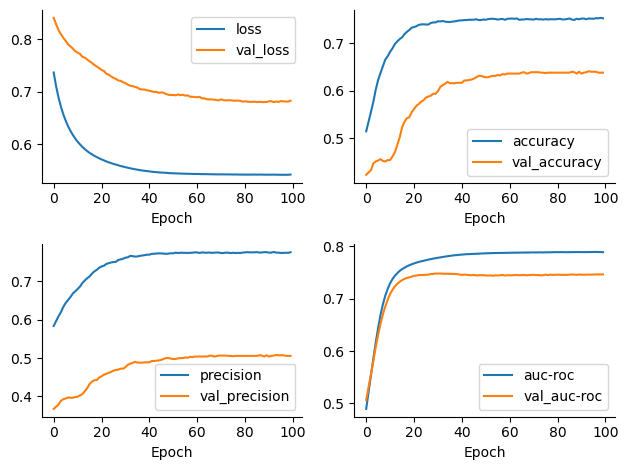

In [13]:
fig, ax = plt.subplots(2,2)
    
def plot_metrics(*metrics, model, title, ax):
    for metric in metrics:
        ax.plot(model.history.history[f'{metric}'], label=f'{metric}')
        ax.set_xlabel('Epoch')
        ax.legend() 
        sns.despine()

plot_metrics('loss', 'val_loss', model = model, title = 'Loss', ax = ax[0,0])
plot_metrics('accuracy', 'val_accuracy', model = model, title = 'Accuracy', ax = ax[0,1])
plot_metrics('precision', 'val_precision', model = model, title = 'Precision', ax = ax[1,0])
plot_metrics('auc-roc', 'val_auc-roc', model = model, title = 'Recall', ax = ax[1,1])
plt.tight_layout()

In [15]:
evalulation = model.evaluate(processor_pipe.X_test, processor_pipe.y_test)
for name, value in zip(model.metrics_names, evalulation):
    print(f'{name}: {value}')

82/82 [==============================] - 1s 9ms/step - loss: 0.5167 - accuracy: 0.7663 - precision: 0.7937 - recall: 0.8357 - auc-roc: 0.8089
loss: 0.5167065858840942
accuracy: 0.7662981152534485
precision: 0.7937352061271667
recall: 0.8357187509536743
auc-roc: 0.8088879585266113


In [65]:
num_cols = list(processor_pipe.processor.transformers_[0][2])
cat_cols = list(processor_pipe.processor.named_transformers_['cat']['ohe'].get_feature_names_out())
cols = num_cols + cat_cols
cols

['mouse_id',
 'day',
 'trial_count',
 'signal_max',
 'signal_min',
 'x0_avoid',
 'x0_cue',
 'x0_escape',
 'x0_shock',
 'x1_D1',
 'x1_D2',
 'x1_DA',
 'x2_F',
 'x2_M']

In [75]:


import re
predictions = model.predict(processor_pipe.X_test)
labels = np.where(predictions > 0.5, 1, 0)
df_test = (pd.DataFrame(processor_pipe.X_test, columns = cols)
           .assign(true_avoids = processor_pipe.y_test.reset_index(drop = True), 
                   predicted_avoids = labels
        #    .rename(columns = lambda c: re.sub(r"^x\d+_", '', c), regex = True)
           )
)
df_test


82/82 [==============================] - 0s 2ms/step


,mouse_id,day,trial_count,signal_max,signal_min,x0_avoid,x0_cue,x0_escape,x0_shock,x1_D1,x1_D2,x1_DA,x2_F,x2_M,true_avoids,predicted_avoids
0,-0.232299,-0.871388,-0.896679,-0.292768,-0.530127,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0
1,-0.232299,-0.384856,-0.481096,-0.359369,0.050119,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1
2,-0.232299,-0.384856,-0.446464,-0.333570,0.122518,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1
3,-0.232299,-0.384856,-0.377200,0.247292,0.892320,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1
4,-0.232299,-0.384856,-0.342568,-0.076106,-0.265448,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2618,1.641618,-0.871388,-1.035207,-0.004019,-0.246582,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0
2619,1.641618,-0.871388,-1.017891,-0.479592,-0.912850,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0
2620,1.641618,-0.384856,-0.533044,-0.491374,0.020312,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0
2621,1.641618,0.588208,0.453966,0.294872,-1.252627,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,1


/Users/mds8301/anaconda3/envs/enigma/lib/python3.11/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


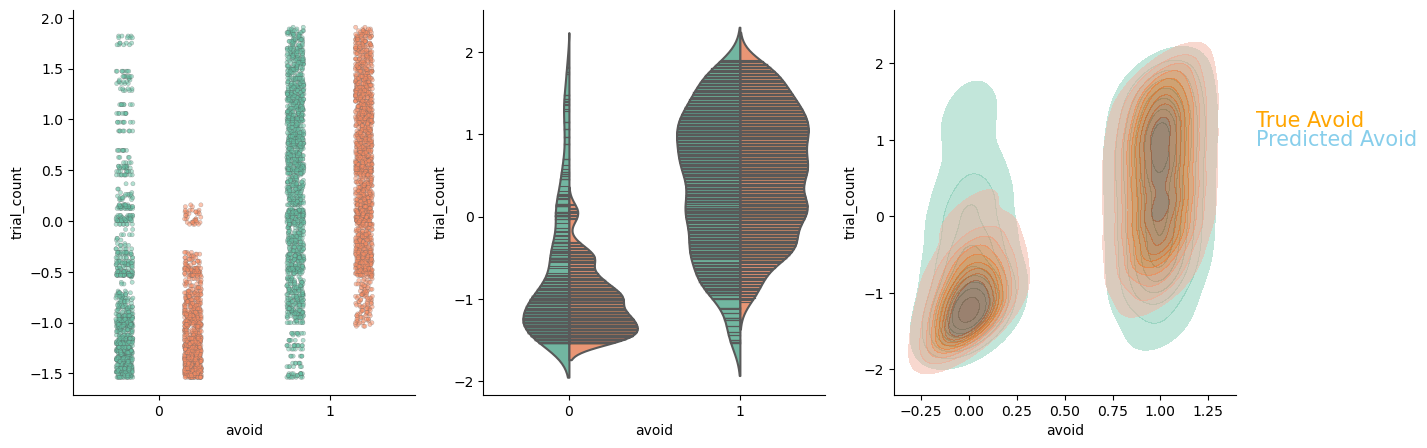

In [139]:
palette = 'Set2'
selected_data = df_test.melt(
    id_vars = df_test.drop(columns = ['true_avoids', 'predicted_avoids']).columns,
     value_vars = ['true_avoids', 'predicted_avoids'], 
     value_name = 'avoid',
     var_name = 'truth')
fig, ax = plt.subplots(1,3, figsize = (15, 5))
sns.stripplot(data = selected_data, 
              x = 'avoid', 
              y = 'trial_count', 
              jitter = True, 
              dodge = True,
              hue = 'truth', 
              linewidth=0.3,
              alpha = 0.5,
              size = 3,
              palette = palette,
              ax = ax[0])
# move the legend to the top
ax[0].legend().remove()
sns.violinplot(data = selected_data, 
              x = 'avoid', 
              y = 'trial_count',
              inner = 'stick',
              split = True,
              hue = 'truth',
              palette=palette,
              alpha = 0.5, 
              ax=ax[1])
ax[1].legend().remove()
sns.kdeplot(data = selected_data,
        x = 'avoid',
        y = 'trial_count',
        hue = 'truth',
        fill=True, 
        alpha = 0.5, 
        palette= palette,
        lw = 0.2,
        ax = ax[2]
        )
ax[2].legend().remove()
# add color text to the figure
ax[2].text(1.5, 1.25, 'True Avoid', size=15, color = 'orange',  ha='left', va='center')
ax[2].text(1.5, 1.0, 'Predicted Avoid', size=15, color = 'skyblue',  ha='left', va='center')

sns.despine() 


<Axes: xlabel='trial_count', ylabel='avoid'>

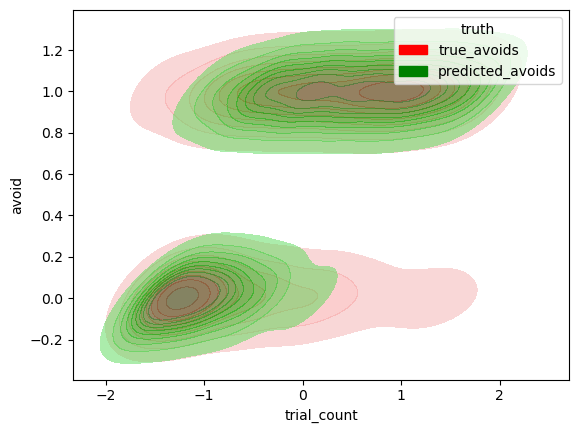

In [97]:
sns.kdeplot(data = selected_data,
        x = 'trial_count',
        y = 'avoid',
        hue = 'truth',
        fill=True, 
        alpha = 0.5, 
        palette= ('red', 'green')
        )